In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import geomstats.backend as gs
import matplotlib.pyplot as plt
import torch


import default_config
from datasets.synthetic import get_synth_immersion
from evaluate import get_model_immersion
from evaluate import compute_extrinsic_curvature
from evaluate import plot_curvature_profile
import evaluate
import numpy as np

INFO: Using pytorch backend


# Evaluate Synthetic Data

## From analytic form of immersion

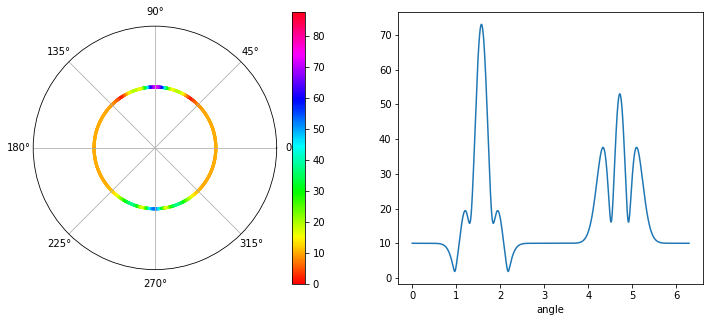

In [2]:
# immersion = get_synth_immersion(
#     radius=default_config.radius,
#     n_wiggles=default_config.n_wiggles,
#     amp_wiggles=default_config.amp_wiggles,
#     embedding_dim=default_config.embedding_dim,
#     rot=default_config.rot,
# )

angles = gs.linspace(0, 2 * gs.pi, 1000)


# mean_curvature_synth, mean_curvature_norm_synth = compute_extrinsic_curvature(
#     angles, immersion, default_config.embedding_dim
# )


mean_curvature_synth, mean_curvature_norm_synth = main_eval.get_mean_curvature_synth(angles , default_config)



plot_curvature_profile(angles, mean_curvature_norm_synth)

In [ ]:
d = np.linspace(0,10,100)

j = d**2 + np.random.normal(0,d)

## Learned immersion via VAE

### Load model

In [8]:
model_filename = "/Users/franciscoacosta/Desktop/code/neuralgeom/neuralgeom/results/trained_models/wiggles_2022-09-12 15:45:00_model.pt"
model = torch.load(model_filename)

model.eval()

VAE(
  (encoder_fc): Linear(in_features=2, out_features=400, bias=True)
  (encoder_linears): ModuleList(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (fc_z_mu): Linear(in_features=400, out_features=2, bias=True)
  (fc_z_logvar): Linear(in_features=400, out_features=1, bias=True)
  (decoder_fc): Linear(in_features=2, out_features=400, bias=True)
  (decoder_linears): ModuleList(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (fc_x_mu): Linear(in_features=400, out_features=2, bias=True)
)

### Compare reconstruction with inputs

Dataset shape: torch.Size([1000, 2]).


/Users/franciscoacosta/Desktop/code/neuralgeom/neuralgeom/notebooks/../datasets/utils.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_torch = torch.tensor(dataset)


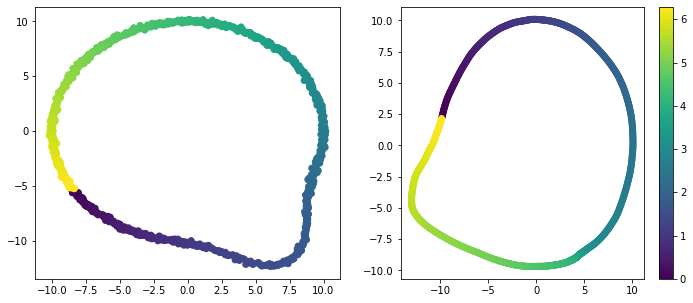

In [9]:
from datasets import utils

dataset_torch, labels, train_loader, test_loader = utils.load(default_config)

x_data = dataset_torch[:,0]
y_data = dataset_torch[:,1]

angles = torch.linspace(0, 2 * gs.pi, 1000)
z = torch.stack([torch.cos(angles), torch.sin(angles)], axis=-1)

rec = model.decode(z)

x_rec = rec[:, 0].cpu().detach().numpy()
y_rec = rec[:, 1].cpu().detach().numpy()

fig = plt.figure(figsize=(12, 5))

ax_data = fig.add_subplot(1, 2, 1)
sc_data = ax_data.scatter(x_data, y_data, c = labels["angles"])

ax_rec = fig.add_subplot(1, 2, 2)

sc_rec = ax_rec.scatter(x_rec, y_rec, c = labels["angles"])

plt.colorbar(sc_rec)

### Visualize Latent Space

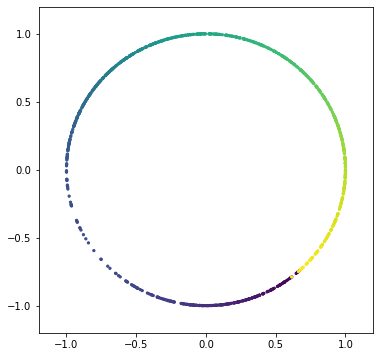

In [10]:
_, posterior_params = model(dataset_torch)

z, _, _ = model.reparameterize(posterior_params)


plt.figure(figsize=(6, 6))
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

z0 = z[:, 0].cpu().detach().numpy()
z1 = z[:, 1].cpu().detach().numpy()

plt.scatter(z0, z1, c=labels["angles"], s=5)

### Visualize learned curvature

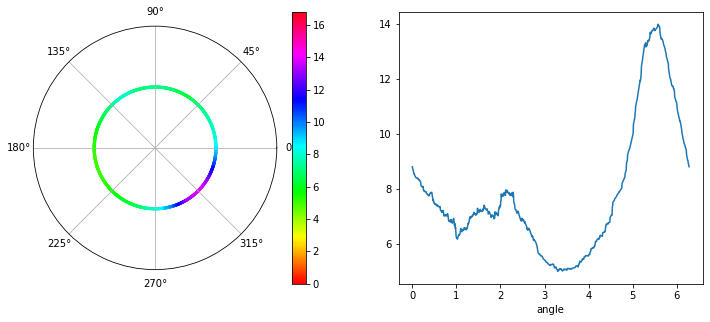

In [11]:
angles = gs.linspace(0, 2 * gs.pi, 1000)

immersion = get_model_immersion(model)

mean_curvature, mean_curvature_norm = compute_extrinsic_curvature(
    angles, immersion, default_config.embedding_dim
)

plot_curvature_profile(angles, mean_curvature_norm)


## Analysis: Analytical vs Learned

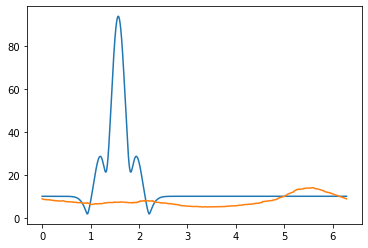

In [12]:
# scaling = float(sum(mean_curvature_norm_synth) / sum(mean_curvature_norm))

# #scaling = 1

# scaling = float(max(mean_curvature_norm_synth) / max(mean_curvature_norm))

# print("scaling factor: " + str(scaling))


#mean_curvature_norm = np.roll(mean_curvature_norm,200)

plt.plot(angles, mean_curvature_norm_synth)
plt.plot(angles, mean_curvature_norm)

-237


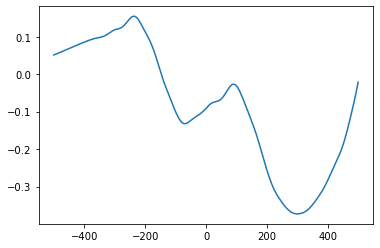

In [13]:
import scipy.signal


s1 = np.squeeze(mean_curvature_norm.detach().numpy())
s1 = s1 - np.mean(s1)

s1 = s1/np.linalg.norm(s1)

s2 = np.squeeze(mean_curvature_norm_synth.detach().numpy())
s2 = s2 - np.mean(s2)
s2 = s2/np.linalg.norm(s2)

#cross_corr = scipy.signal.correlate(s1, s2, mode="same")


correlation = np.correlate(s1, s2, mode="same")
lags = scipy.signal.correlation_lags(s1.size, s2.size, mode="same")
lag = lags[np.argmax(correlation)]
plt.plot(lags,correlation)
print(lag)

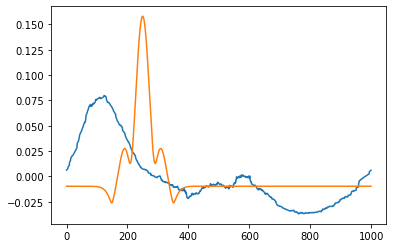

In [14]:
plt.plot(np.roll(s1,-lag))
plt.plot(s2)

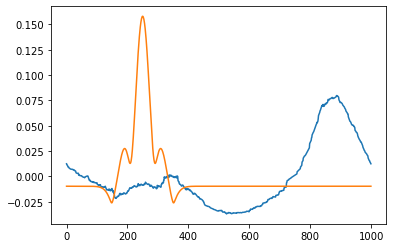

In [18]:
plt.plot(s1)
plt.plot(s2)

In [15]:
max(correlation)

0.15457569

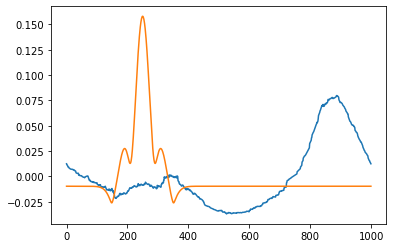

In [16]:
f = plt.figure()

ax1 = f.add_subplot(111)

ax1.plot(s1)
ax1.plot(s2)

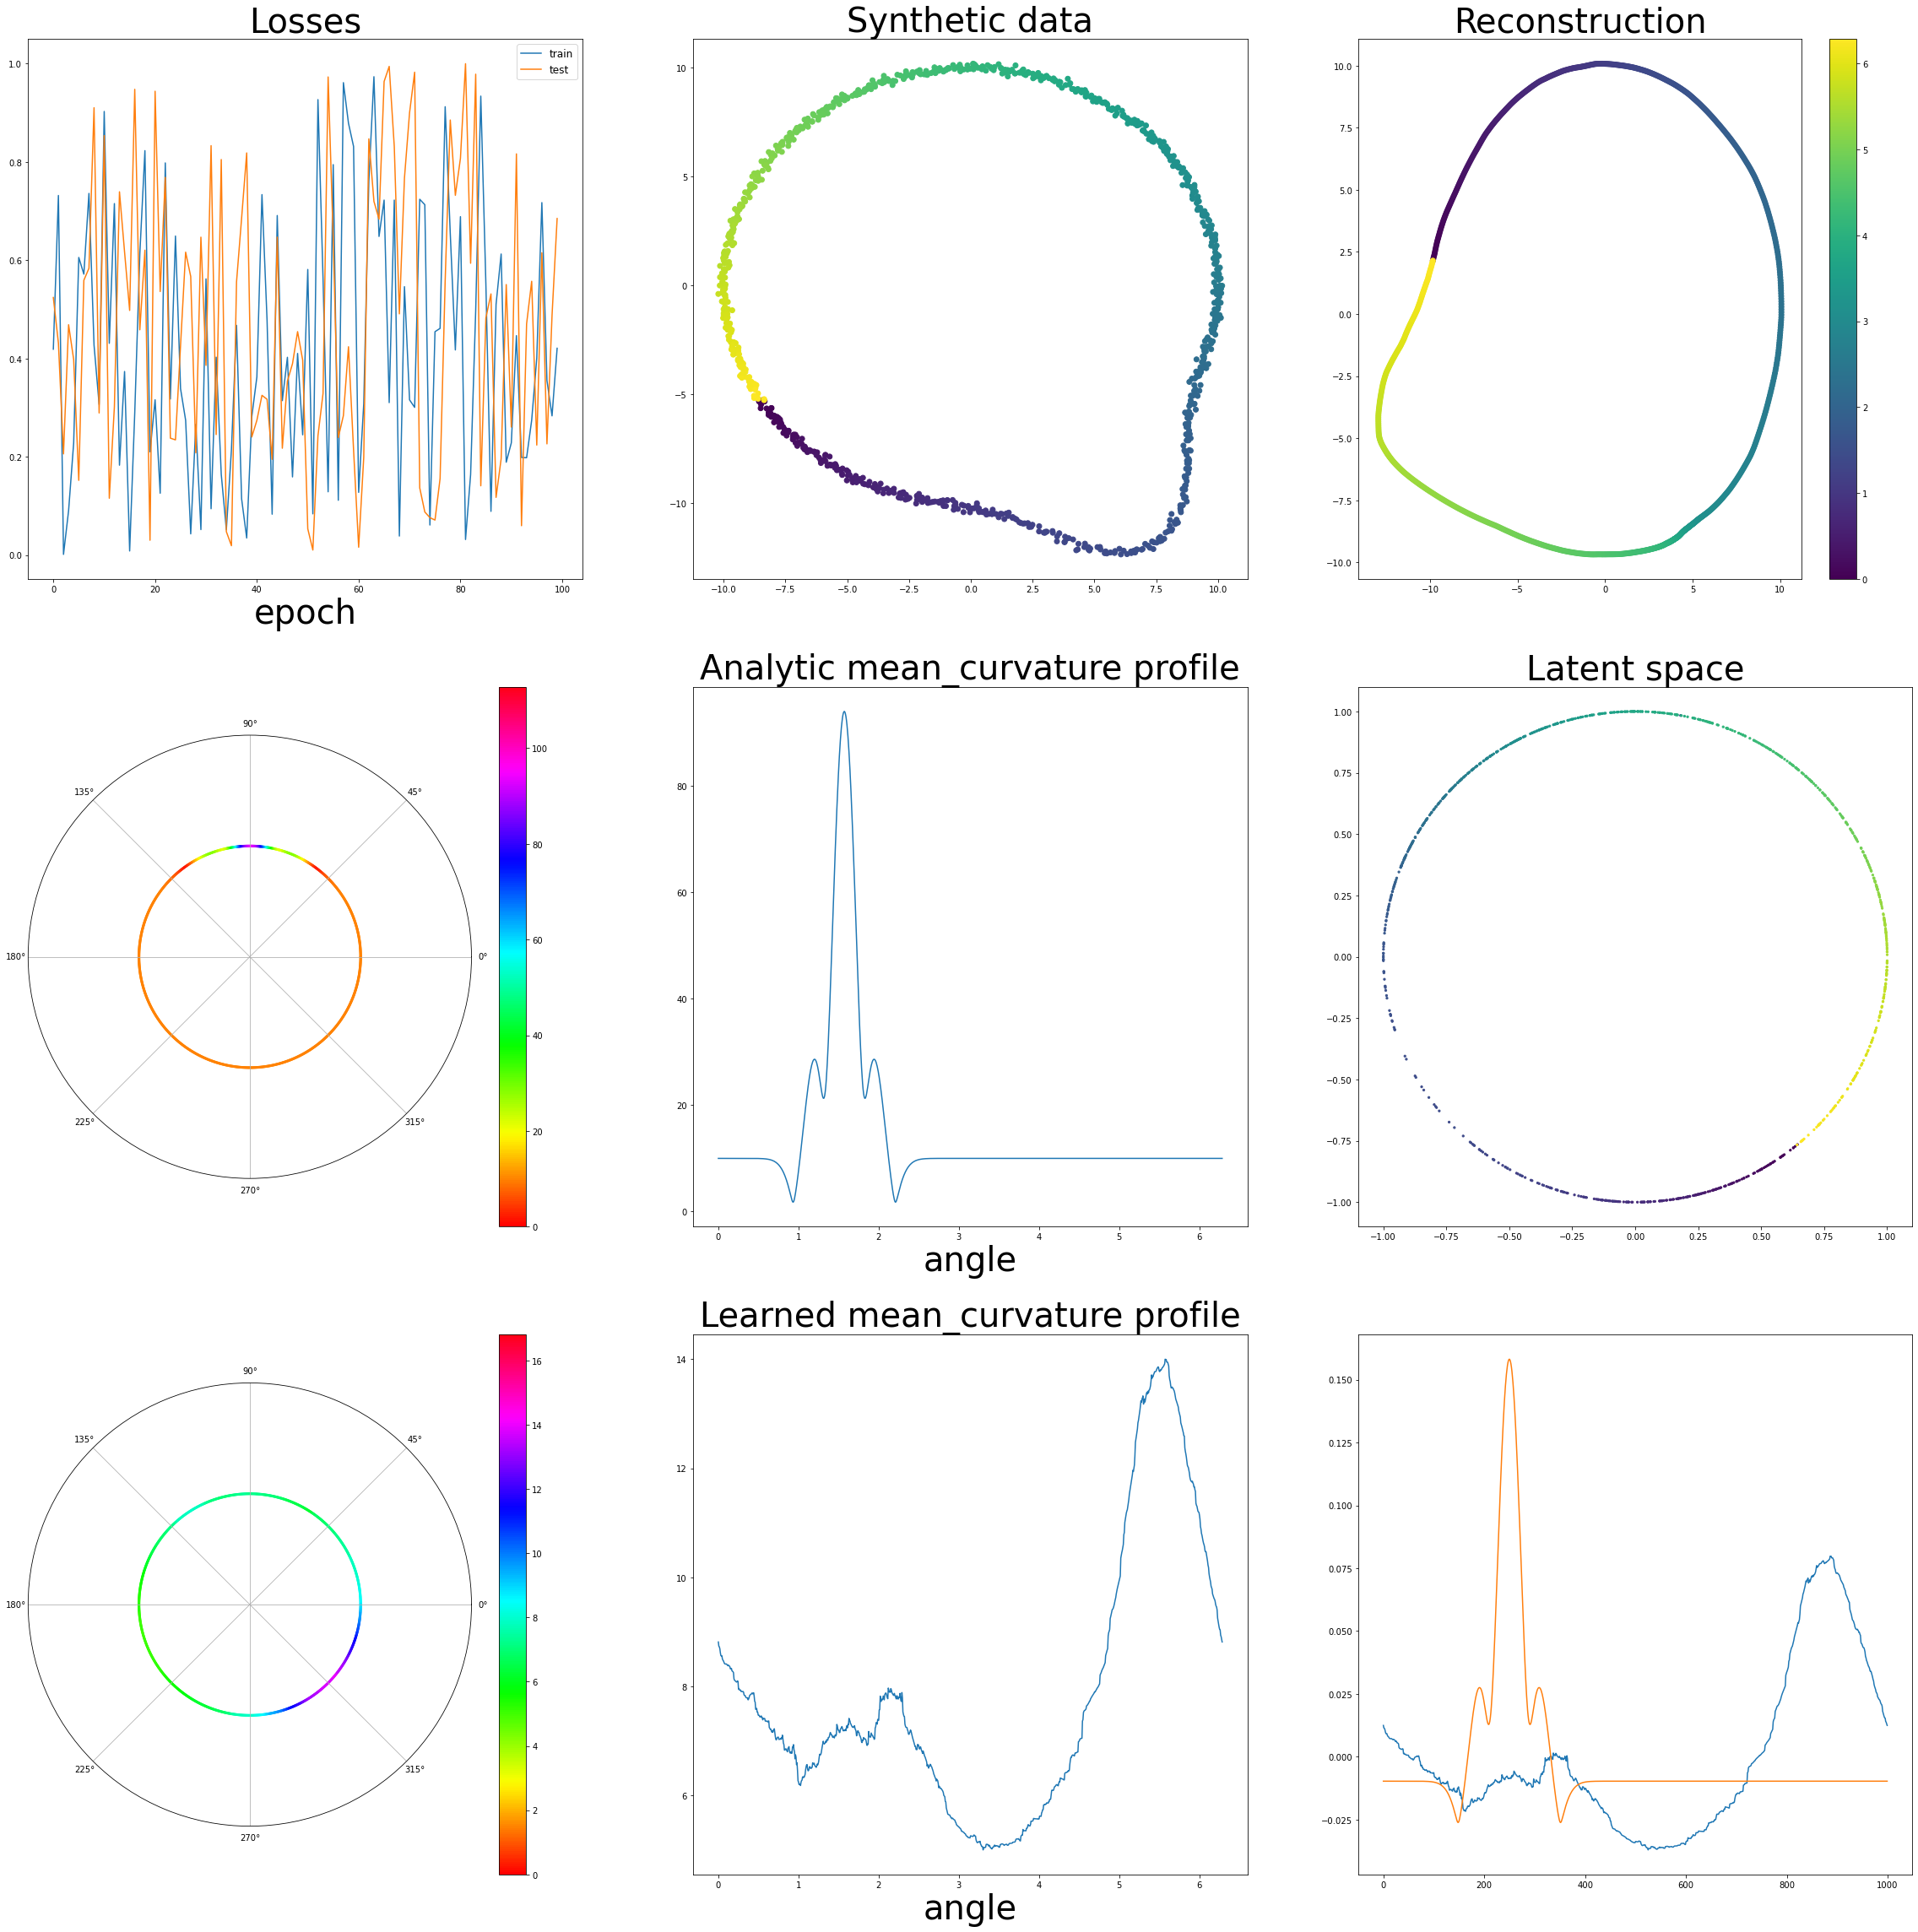

In [20]:
import evaluate
train_losses = torch.rand(100)
test_losses = torch.rand(100)
main_eval.master_plot(model, dataset_torch, labels, angles, mean_curvature_norm, mean_curvature_norm_synth, s1, s2, train_losses, test_losses, config=default_config)

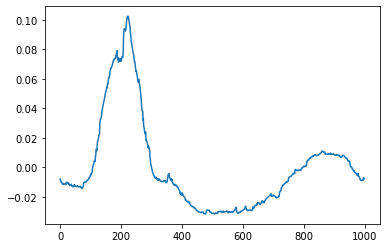

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(s1)

plt.savefig("../results/fig.png")